# 初始化

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')  # 返回notebook的上一级目录
# sys.path.append('E:\GitHub\QA-abstract-and-reasoning')  # 效果同上

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
np.set_printoptions(suppress=True)
from utils.plot import plot_attention
from utils.saveLoader import *
from utils.config import *
from layers import *
from preprocess import Preprocess
from gensim.models.word2vec import LineSentence, Word2Vec
import tensorflow as tf
# from model_layer import seq2seq_model
import time
tf.__version__

'2.0.0'

[限制gpu内存增长](https://tensorflow.google.cn/guide/gpu#limiting_gpu_memory_growth)

In [3]:
from utils.config_gpu import config_gpu
config_gpu()

1 Physical GPUs, 1 Logical GPUs


## 加载数据

In [4]:
train_x,train_y,test_x = load_train_dataset()  # 数据集
vocab,vocab_reversed = load_vocab(VOCAB_PAD)  # vocab
embedding_matrix = np.loadtxt(EMBEDDING_MATRIX_PAD)  # 预训练层

## 设置参数

In [5]:
params = {}
params["vocab_size"] = len(vocab)
params["max_enc_len"] = train_x.shape[1]  # 260
params["max_dec_len"] = train_y.shape[1]  # 33
params["embed_size"] = embedding_matrix.shape[1]
params["enc_units"] = 32
params["attn_units"] = 10
params["dec_units"] = params["enc_units"]
params["batch_size"] = 8
params["epochs"] = 2
print(params)

{'vocab_size': 32566, 'max_enc_len': 260, 'max_dec_len': 33, 'embed_size': 300, 'enc_units': 32, 'attn_units': 10, 'dec_units': 32, 'batch_size': 8, 'epochs': 2}


## 构建训练集

In [6]:
# 取部分数据进行训练
sample_num=64
dataset = tf.data.Dataset.from_tensor_slices((train_x[:sample_num], train_y[:sample_num])).shuffle(params["batch_size"]*2+1)
dataset = dataset.batch(params["batch_size"], drop_remainder=True)

In [7]:
steps_per_epoch = sample_num//params["batch_size"]

## 构建模型

In [8]:
from seq2seq import *
model=Seq2Seq(params)

## 保存点设置

In [9]:
from utils.config import CKPT_DIR, CKPT_PREFIX
ckpt = tf.train.Checkpoint(Seq2Seq=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, CKPT_DIR, max_to_keep=5)

In [10]:
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


## 训练

[SparseCategoricalCrossentropy](https://tensorflow.google.cn/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)

In [11]:
optimizer = tf.keras.optimizers.Adam(name='Adam',learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

pad_index=vocab['<PAD>']
unk_index=vocab['<UNK>']

def loss_function(real, pred):
    pad_mask = tf.math.equal(real, pad_index)
    unk_mask = tf.math.equal(real, unk_index)
    # <PAD> 和 <UNK> 的损失都不算
    mask = tf.math.logical_not(tf.math.logical_or(pad_mask,unk_mask))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)
    # return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [12]:
@tf.function
def train_step(inp, targ):
    pad_index=vocab['<PAD>']
    unk_index=vocab['<UNK>']
    loss = 0
    
    with tf.GradientTape() as tape:
        # 1. 构建encoder
        enc_output, enc_hidden = model.call_encoder(inp)
        # 2. 复制
        dec_hidden = enc_hidden
        # 3. <START> * BATCH_SIZE 
        dec_input = tf.expand_dims([vocab['<START>']] * params["batch_size"], 1)
        
        # 逐个预测序列
        predictions, _ = model(dec_input, dec_hidden, enc_output, targ)
        
        batch_loss = loss_function(targ[:, 1:], predictions)

        variables = model.encoder.trainable_variables + model.decoder.trainable_variables+ model.attention.trainable_variables
    
        gradients = tape.gradient(batch_loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [13]:
epochs = params["epochs"]
# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
for epoch in range(epochs):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 1 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.4501
Epoch 1 Batch 1 Loss 7.2250
Epoch 1 Batch 2 Loss 4.4649
Epoch 1 Batch 3 Loss 3.8155
Epoch 1 Batch 4 Loss 5.7638
Epoch 1 Batch 5 Loss 5.3579
Epoch 1 Batch 6 Loss 4.8302
Epoch 1 Batch 7 Loss 5.7638
Epoch 1 Loss 5.0839
Time taken for 1 epoch 104.9479079246521 sec

Epoch 2 Batch 0 Loss 4.5461
Epoch 2 Batch 1 Loss 7.1438
Epoch 2 Batch 2 Loss 5.0332
Epoch 2 Batch 3 Loss 4.7490
Epoch 2 Batch 4 Loss 4.1808
Epoch 2 Batch 5 Loss 4.9926
Epoch 2 Batch 6 Loss 4.1402
Epoch 2 Batch 7 Loss 5.8855
Saving checkpoint for epoch 2 at E:\GitHub\QA-abstract-and-reasoning\data\checkpoints\training_checkpoints\ckpt-1
Epoch 2 Loss 5.0839
Time taken for 1 epoch 4.093861818313599 sec



In [14]:
assert False

AssertionError: 

## 载入模型

In [ ]:
# 如果检查点存在，则恢复最新的检查点。
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

In [66]:
def evaluate(model,inputs):
    attention_plot = np.zeros((params["max_dec_len"], params["max_enc_len"]))
    
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    hidden = [tf.zeros((1, params["enc_units"]))]
    enc_output, enc_hidden = model.encoder(inputs, hidden)

    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([vocab['<START>']], 0)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)

    for t in range(params["max_dec_len"]):
        
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += vocab_reversed[predicted_id] + ' '
        if vocab_reversed[predicted_id] == '<STOP>':
            return result, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [75]:
def translate(sentence):
    st = preproc.sentence_proc(sentence)
    sentence = preproc.sentence_proc_eval(sentence,params["max_enc_len"]-2,vocab)
    result, attention_plot = evaluate(model,sentence)

    print('Input: %s' % (st))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(st.split(' '))]
    plot_attention(attention_plot, st.split(' '), result.split(' '))

In [76]:
preproc = Preprocess()
preproc.sentence_proc(sentence)

'方向机 重 助力 泵 方向机 都 换'

In [77]:
# import matplotlib as mpl
# mpl.rcParams['font.family'] = 'STSong'  # 显示中文

Input: 方向机 重 助力 泵 方向机 都 换
Predicted translation: 开票 老哥 改原车 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 信不过 


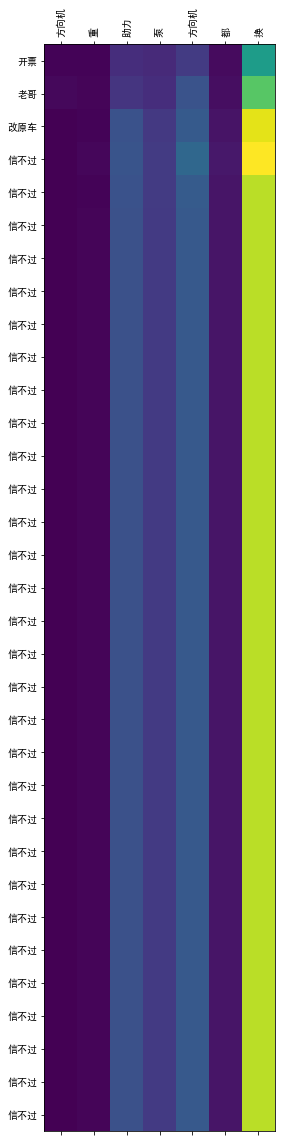

In [78]:
sentence = '方向机重，助力泵，方向机都换了还是一样'
translate(sentence)